In [147]:
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import wavfile
import matplotlib.pyplot as plt

root = os.path.join('..', '..', 'data')

class AutoVivification(dict):
    """
    Allows dynamic creation of dict keys upon query.
    If key queried does not exist, creates empty dict under it.
    """

    def __getitem__(self, item):
        try:
            return dict.__getitem__(self, item)
        except KeyError:
            value = self[item] = type(self)()
            return value

class Dataset():
    def __init__(self, root_dir):
        """"""
        # Constructs database as dictionary of paths
        db = AutoVivification()
        for path in glob.glob(os.path.join(root_dir, 'training_data', '*')):
            base = os.path.basename(path)
            filename, extension = os.path.splitext(base)
            if extension == '.txt':
                patient = filename
                db[patient]['txt'] = path
            elif extension in ('.hea', '.tsv', '.wav'):
                basesplit = base.split('_')
                if len(basesplit) == 2:
                    patient, valvename = filename.split('_')
                    db[patient]['recordings'][valvename]['0'] = path
                else:
                    patient, valvename, valveid = filename.split('_')
                    db[patient]['recordings'][valvename][valveid] = path
            else:
                raise RuntimeError(f"Unexpected file type: {base}")
        self.db = db
        
        # Loads metadata CSV
        self.meta = pd.read_csv(os.path.join(root_dir, 'training_data.csv'), index_col=0)
        
    def get_patient(self, patient):
        return Patient(patient, self.db[str(patient)], self.meta.loc[int(patient), :])
    
    def __iter__(self):
        for patient in sorted(db):
            yield Patient(patient, self.db[str(patient)], self.meta.loc[int(patient), :])
    
class Patient():
    def __init__(self, uid, db, meta):
        self.uid = uid
        # 
        for k, v in dict(meta).items():
            setattr(self, k, v)
        # 
        with open(db['txt']) as f:
            self.info = f.readlines()
        # 
        self.recordings = dict()
        for valvename in db['recordings']:
            self.recordings[valvename] = dict()
            for valveid in db['recordings'][valvename]:
                self.recordings[valvename][valveid] = dict()
                samplerate, data = wavfile.read(db['recordings'][valvename][valveid])
                self.recordings[valvename][valveid]['samplerate'] = samplerate
                self.recordings[valvename][valveid]['data'] = data
        
    def __str__(self):
        for attr in dir(self):
            if not(attr.startswith('_')):
                print(attr, ':', getattr(self, attr))
                
    def show_trace(self, valvename, valveid):
        N = self.recordings[valvename][valveid]['data'].shape[0]
        T = 1 / self.recordings[valvename][valveid]['samplerate']
        time = T * np.arange(0, N)
        plt.plot(time, self.recordings[valvename][valveid]['data'])
        plt.xlabel('Time (s)')
        plt.ylabel('AU')
        plt.grid()
        plt.title(f'Patient {self.uid}: {valvename} Valve (Recording {valveid})')

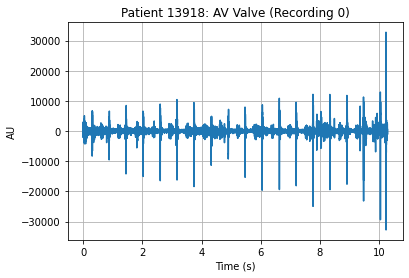

In [148]:
# Instantiating the dataset
dataset = Dataset(root)

# Loading a patient
patient = dataset.get_patient('13918')

# Plotting one heart trace
patient.show_trace('AV', '0')